In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# we read the attribute names and store them in the columns var
with open("data/communities.names") as f: 
    columns = [l.split(" ")[1] for l in f.readlines() if l.startswith("@attribute")]
# we read the data file and store it in the dataframe
df = pd.read_csv('data/communities.data', header=None, names=columns, na_values='?')
# dropping first 5 columns
df = df.drop(columns=["state", "county", "community", "communityname", "fold"]) 

# Dropping columns with NaN values
df.dropna(axis=1, inplace=True)

df.head()
df.shape

(1994, 100)

In [3]:
# K-fold cross-validation and Leave-one-out cross-validation

def k_fold_split(data, k): # returns k folds of the data
    data = np.array(data)
    np.random.shuffle(data)  # Shuffle the data for randomness
    fold_size = math.ceil(len(data) / k)
    folds = [data[i:i + fold_size] for i in range(0, len(data), fold_size)]
    return folds

def k_fold_cross_validation(model, data, k=2):
    folds = k_fold_split(data, k) # splitting the data into k folds
    scores = []

    for i in range(k):
        # using one of the folds in each iteration for testing, others for training the model
        test_set = folds[i]
        train_set = np.concatenate([folds[j] for j in range(k) if j != i])

        # fitting the model with train set
        model.fit(train_set)

        # testing the model (mse)
        score = model.evaluate(test_set)
        scores.append(score)
    
    return np.mean(scores) # returns the mean of MSE

def leave_one_out_cross_validation(model, data):
    return k_fold_cross_validation(model, data, k=data.shape[0]) # calling k_folds with k = 1


In [4]:
# defining custom linear regression (using sklearn's LinearRegression)
class CustomLinearRegression:
    def __init__(self):
        self.model = LinearRegression()

    # fitting the data
    def fit(self, data):
        X, y = data[:, :-1], data[:, -1] # splitting to X and y (y is the last column in data)
        self.model.fit(X, y)

    # evaluating the model
    def evaluate(self, data):
        X, y = data[:, :-1], data[:, -1] # splitting to X and y (y is the last column in data)
        y_pred = self.model.predict(X) # calcualting the y predictions
        mse = mean_squared_error(y, y_pred)  # calculating the mean squared error
        return mse
    
    def predict(self, X):
        return self.model.predict(X)

In [5]:
import sys
# implementing forward feature selection

def forward_feature_selection(model, df, k):
    y = np.array(df)[:,-1]
    data = np.array(df)[:,:-1] # converting df to numpy array and removing the last column (y values)
    mse_list = []
    mse_list.append(sys.float_info.max)

    for i in range(len(data[0])):
        best_mse = sys.float_info.max
        best_atribute = None
        for column in data.T: # looking for the best atribute
            new_data = np.c_[column, y]
            cur_mse = k_fold_cross_validation(model, new_data, k)
            if cur_mse < best_mse:
                best_mse = cur_mse
                best_atribute = column
        if best_mse >= mse_list[-1]:
            break
        mse_list.append(best_mse)
        y = np.c_[best_atribute,y]
    return y, mse_list[1:]


def forward_feature_selection_with_atributes(model, df, k):
    # getting the y values from the df
    y = np.array(df)[:,-1]
    mse_list = []
    mse_list.append(sys.float_info.max) # error prevention (wont return this element at the end)
    atribute_names_list = []

    df_new = df.drop(df.columns[-1], axis=1) # dropping the y from df

    for i in range(df.shape[1] - 1):
        best_mse = sys.float_info.max
        best_column = None
        best_atribute_name = None
        for column_name in df_new.columns:
            column = df_new[column_name]
            new_data = np.c_[np.array(column), y]
            cur_mse = k_fold_cross_validation(model, new_data, k)
            if cur_mse < best_mse:
                best_mse = cur_mse
                best_column = column
                best_atribute_name = column_name
        if best_mse >= mse_list[-1]:
            break
        mse_list.append(best_mse)
        y = np.c_[np.array(best_column), y]
        atribute_names_list.append(best_atribute_name)

    return y, mse_list[1:], atribute_names_list



In [6]:
custom_model = CustomLinearRegression()

features_and_y, mse_list, atributes_list = forward_feature_selection_with_atributes(custom_model, df, 5)

In [7]:
atributes_list

['PctKids2Par',
 'racePctWhite',
 'HousVacant',
 'pctUrban',
 'PctPersDenseHous',
 'racepctblack',
 'MalePctDivorce',
 'PctWorkMom',
 'PctPopUnderPov',
 'MedRentPctHousInc',
 'NumStreet',
 'population',
 'PctKids2Par',
 'PctIlleg',
 'pctUrban',
 'pctWFarmSelf',
 'RentLowQ',
 'PctEmplProfServ',
 'MedRent',
 'MalePctNevMarr']

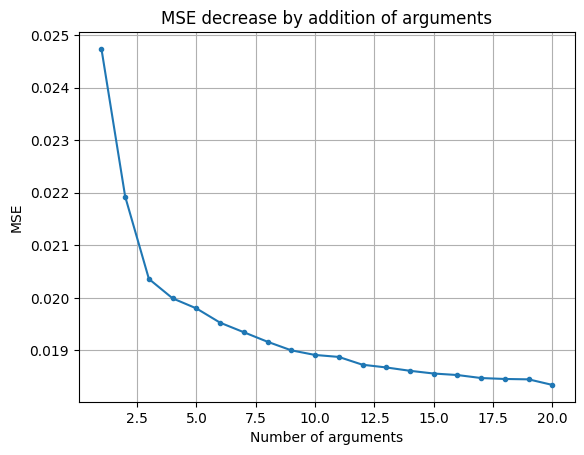

In [8]:
x_values = range(1, len(mse_list) + 1)
plt.plot(x_values, mse_list, marker='.', linestyle='-')
plt.title('MSE decrease by addition of arguments')
plt.xlabel('Number of arguments')
plt.ylabel('MSE')
plt.grid(True)

# Show the plot
plt.show()

In [9]:
# Bootstraping TODO